In [1]:
import seaborn as sns
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'

In [2]:
import matplotlib as mpl
print(mpl.get_cachedir())

/data/lijingru/.cache/matplotlib


### Choose the root of KD
Find the original root directory of KD.

In [2]:
!ls ../save/student_model/resnet28x10_cifar100_lr_0.0002_decay_0_buffer_size_50000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_4

best.txt	 img_samples	pxy_energy.npy	res_epoch_80.pts
hyper		 log.txt	qx_energy.npy	sample_10_perclass.png
img_sample_eval  px_energy.npy	qxy_energy.npy


In [2]:
device = 'cuda:4'
ckpt_res = torch.load('../save/student_datafree_model/S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.1_a:0.9_b:0.0_6_df_40000/resnet8x4_best.pth', map_location=device)
ckpt_res.keys()

ckpt_teacher = torch.load('/data/lijingru/EBKD/save/models/resnet32x4_vanilla/ckpt_epoch_240.pth', map_location=device)
ckpt_teacher.keys()

ckpt_energy = torch.load('//data/lijingru/EBKD/save/student_model/cifar10_lr_0.002_decay_0.0_ndf_256_trial_1_resnet28x10_cifar10_lr_0.0003_decay_0_buffer_size_40000_lpx_1.0_lpxy_0.0_energy_mode_mcmc_step_size_1_g_steps_20_trial_1//res_epoch_300.pts', map_location=device)
ckpt_energy.keys()

dict_keys(['model_state_dict', 'G_state_dict', 'optG', 'optE'])

In [3]:
import sys
sys.path.append('..')
from models.resnet import resnet8x4, resnet32x4
from models import model_dict

model_score = model_dict['resnet28x10'](num_classes=10, norm='none', depth=28, widen_factor=10)
model_score = model_dict['Gen'](model=model_score, n_cls=10)
model_score.load_state_dict(ckpt_energy['model_state_dict'])
model_score.to(device)
model_score.eval()

model = resnet8x4(num_classes=100, norm='batch')
model = model.to(device)
model.load_state_dict(ckpt_res['model'])
model.eval()

teacher = resnet32x4(num_classes=100, norm='batch')
teacher = teacher.to(device)
teacher.load_state_dict(ckpt_teacher['model'])
teacher.eval()

| Wide-Resnet 28x10


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [7]:
class Option:
    def __init__(self):
        self.device = device
        self.augment = False
        self.short_run = False
        self.g_steps = 40
        self.step_size = 1
        self.batch_size = 256
        self.reinit_freq = 0.
        self.dataset = 'cifar10'
        self.n_cls = 10
        self.save_dir = './tmp/exp5/'
        self.save_folder = './tmp/'
        self.capcitiy = 40000
        self.save_grid = False
        self.use_lc = False

import os
opt = Option()
if not os.path.exists(opt.save_dir):
    os.mkdir(opt.save_dir)
    


In [8]:
from helper.sampling import langevin_at_x, init_random
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import tqdm
from helper.util import inception_score
from datasets.cifar100 import CIFAR100Gen
import torchvision.transforms as T
from helper.util_gen import cond_samples
 

sample_q = langevin_at_x(opts=opt, device=device)
#replay_buffer = ckpt_energy['replay_buffer'].cpu()
replay_buffer = init_random((opt.capcitiy, 3, 32, 32))
print(replay_buffer.shape)
y = torch.arange(0, opt.n_cls).to(device)

sqrt = lambda x: int(torch.sqrt(torch.Tensor([x])))
plot = lambda x: vutils.make_grid(torch.clamp(x, -1, 1), normalize=True, nrow=sqrt(x.size(0)))


torch.Size([40000, 3, 32, 32])


Epoch 0 / 6001 ****


100%|██████████| 10/10 [09:07<00:00, 54.76s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.


/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


IS: 1.2506382037311574 +- 0.0009965790366683698
Epoch 200 / 6001 ****


100%|██████████| 10/10 [09:01<00:00, 54.17s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.
IS: 1.369235676796644 +- 0.002272128308711956
Epoch 400 / 6001 ****


100%|██████████| 10/10 [09:07<00:00, 54.79s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.
IS: 1.4629742937046402 +- 0.0030097794916121635
Epoch 600 / 6001 ****


100%|██████████| 10/10 [09:00<00:00, 54.01s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.
IS: 1.5401516943207358 +- 0.002554876282439118
Epoch 800 / 6001 ****


100%|██████████| 10/10 [09:00<00:00, 54.09s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.
IS: 1.6044688627900705 +- 0.005414279418911123
Epoch 1000 / 6001 ****


100%|██████████| 10/10 [08:59<00:00, 53.98s/it]


Successfully saving the generated result of replay buffer.
Successfully save the result.
IS: 1.6606864273948119 +- 0.005688978304776847


KeyboardInterrupt: 

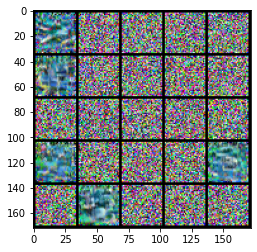

In [9]:
freshh_epochs = 6001
for i in range(freshh_epochs):
    samples, _ = sample_q(model_score, replay_buffer, y=y)
    if i % 200 == 0:
        print('Epoch {} / {} ****'.format(i, freshh_epochs))
        buffer_size = len(replay_buffer)
        inds = torch.randint(0, buffer_size, (25,))
        sampled = replay_buffer[inds]
        imgs = plot(sampled).cpu()
        img = np.transpose(imgs, (1,2,0))
        plt.figure(10)
        plt.imshow(img)
        replay_buffer = cond_samples(model_score, replay_buffer, device, opt, use_buffer=True)
        test_folder = opt.save_dir
        dataset = CIFAR100Gen(
            root=test_folder,
            transform=T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
        )
        mean, var = inception_score(dataset, device, resize=True, splits=3, batch_size=8)
        print('IS: {} +- {}'.format(mean, var))

In [5]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_set = CIFAR100(root='/data/lijingru/cifar100', download=False, train=False, transform=test_transform)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         shuffle=False,
                         num_workers=1)

In [6]:
import tqdm
stu_incorrects = {'probs':[], 'energys':[]}
tea_incorrects = {'probs':[], 'energys':[]}
all_data = {'probs':[], 'energys':[]}

for idx, data in tqdm.tqdm(enumerate(test_loader)):
    x, y = data
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    y_pred_tea = teacher(x)
    energy = model_score(x, y=y)[0]
    all_data['energys'].append(energy.item())
#     all_data['data'].append(x[0].cpu().numpy().tolist())
    all_data['probs'].append(y_pred[0].detach().cpu().numpy().tolist())
    hard_y = y_pred.argmax(1)[0]
    hard_tea_y = y_pred_tea.argmax(1)[0]
#     print(hard_y, hard_tea_y, y)
    if hard_y != y[0]:
#         incorrects['data'].append(x[0].cpu().numpy())
        stu_incorrects['probs'].append(y_pred[0].detach().cpu().numpy().tolist())
        stu_incorrects['energys'].append(energy.item())
    if hard_tea_y != y[0]:
        tea_incorrects['probs'].append(y_pred_tea[0].detach().cpu().numpy().tolist())
        tea_incorrects['energys'].append(energy.item())
        
print('All data: {}'.format(len(all_data['probs'])))
print('Teacher incorrect: {}'.format(len(tea_incorrects['probs'])))
print('Student incorrect: {}'.format(len(stu_incorrects['probs'])))

10000it [04:27, 37.38it/s]

All data: 10000
Teacher incorrect: 2791
Student incorrect: 4807


In [7]:
import json
with open('all.json', 'w') as f:
    f.write(json.dumps(all_data, ensure_ascii=False, indent=4, separators=(',', ':')))
    
with open('incorrect_stu.json', 'w') as f:
    f.write(json.dumps(stu_incorrects, ensure_ascii=False, indent=4, separators=(',', ':')))
    
with open('incorrect_tea.json', 'w') as f:
    f.write(json.dumps(tea_incorrects, ensure_ascii=False, indent=4, separators=(',', ':')))

### Plot distribution of incorrect samples

In [2]:
with open('all.json', 'r') as f:
    all_data = json.load(f)
    
with open('incorrect_stu.json') as f:
    stu_incorrects = json.load(f)
    
with open('incorrect_tea.json') as f:
    tea_incorrects = json.load(f)

<AxesSubplot:ylabel='Density'>

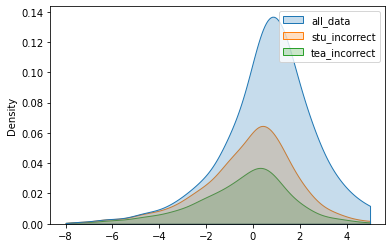

In [3]:
import seaborn as sns
sns.kdeplot(data={'all_data': all_data['energys'], 'stu_incorrect': stu_incorrects['energys'], 'tea_incorrect': tea_incorrects['energys']}, clip=(-8, 5), fill=True)

In [4]:
logos = ['k_10']
for logo in logos:
    scores = []
    for i in range(10):
        pths = torch.load('save/student_datafree_model/S:resnet8x4_T:resnet32x4_svhn_kd_r:0.4_a:0.6_b:0.0_{}_{}/resnet8x4_best.pth'.format(i, logo))
        acc = pths['best_acc']
        scores.append(acc.item())
    scores = np.asarray(scores)
    print('T:resnet32x4, S:resnet8x4, logo:{},  acc:{} +- {}'.format(logo, np.mean(scores), np.var(scores) ** 0.5))

T:resnet32x4, S:resnet8x4, logo:k_10,  acc:93.28749084472656 +- 0.17234420576255796


In [3]:
logos = [ 'k_1', 'k_3', 'k_5_random', 'k_7', 'K_10', 'k_5_st_0']
data = []
for logo in logos:
    scores = []
    for i in range(10):
        pths = torch.load('../save/student_datafree_model/S:resnet8x4_T:resnet32x4_cifar100_kd_r:0.4_a:0.6_b:0.0_{}_{}/resnet8x4_best.pth'.format(i, logo))
        acc = pths['best_acc']
        scores.append(acc.item())
    scores = np.asarray(scores)
    data.append(scores)
    print('T:resnet32x4, S:resnet8x4, logo:{},  acc:{} +- {}'.format(logo, np.mean(scores), np.var(scores) ** 0.5))

data = np.asarray(data)

T:resnet32x4, S:resnet8x4, logo:k_1,  acc:49.325 +- 0.2868534212003394
T:resnet32x4, S:resnet8x4, logo:k_3,  acc:49.1929988861084 +- 0.3580241197970265
T:resnet32x4, S:resnet8x4, logo:k_5_random,  acc:48.90799903869629 +- 0.33053914005596197
T:resnet32x4, S:resnet8x4, logo:k_7,  acc:48.617998886108396 +- 0.4188271381278761
T:resnet32x4, S:resnet8x4, logo:K_10,  acc:49.81899909973144 +- 0.4344984569475255
T:resnet32x4, S:resnet8x4, logo:k_5_st_0,  acc:47.38199882507324 +- 0.41602408963061016


In [4]:
import pandas as pd
logos = [ f'$K=1$', f'$K=3$', f'$K=5$', f'$K=7$', f'$K=10$', f'$K=0$']
real_data = pd.DataFrame(data=data.T, columns=logos)
real_data

,$K=1$,$K=3$,$K=5$,$K=7$,$K=10$,$K=0$
0,48.750000,49.889999,49.209999,49.219997,49.360001,46.989998
1,49.340000,49.590000,48.899998,49.270000,48.989998,47.360001
2,49.180000,49.209999,49.029999,48.070000,49.360001,47.549999
3,49.610001,49.139999,48.489998,48.320000,50.259998,46.820000
4,49.759998,48.840000,48.969997,48.590000,50.059998,48.009998
5,49.389999,48.969997,48.910000,48.529999,49.889999,47.799999
6,49.020000,49.250000,49.270000,48.379997,49.949997,46.919998
7,49.520000,48.629997,48.889999,48.079998,49.799999,47.699997
8,49.520000,49.469997,48.160000,49.090000,50.020000,46.919998
9,49.160000,48.939999,49.250000,48.629997,50.500000,47.750000


In [8]:
ax = sns.boxplot(data=real_data)
# ax.set_xlabel(r'采样步数$K$')
# ax.set_ylabel('学生模型准确率')
y_ticks = np.arange(47, 50.6, 0.5)
plt.xlabel(r'采样步数$K$', fontsize=16)
plt.ylabel(r'学生模型准确率', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(y_ticks, fontsize=14)

([<matplotlib.axis.YTick at 0x7faf34345e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 1 Axes>